総フレーム数:  449.0
fps:  29.97002997002997
動画の長さ:  14.981633333333333 [sec]
720


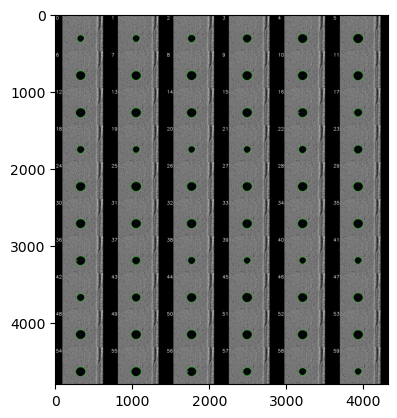

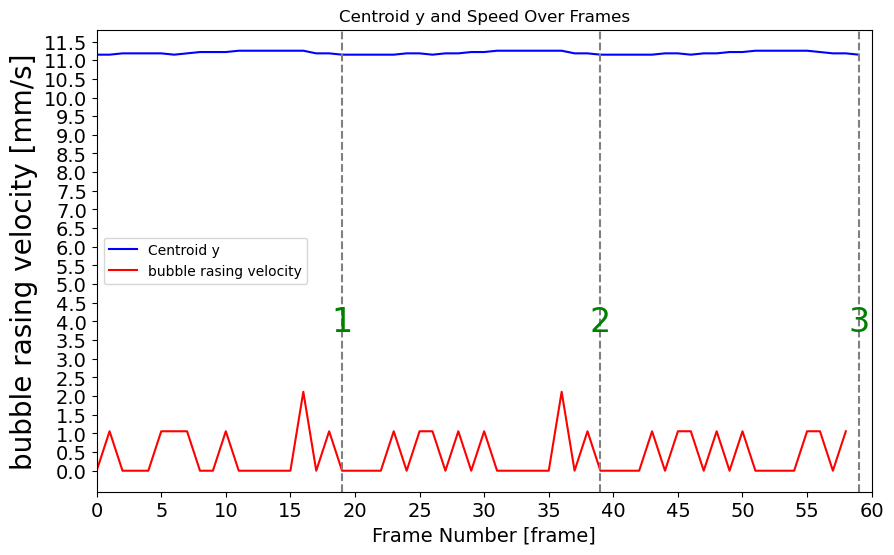

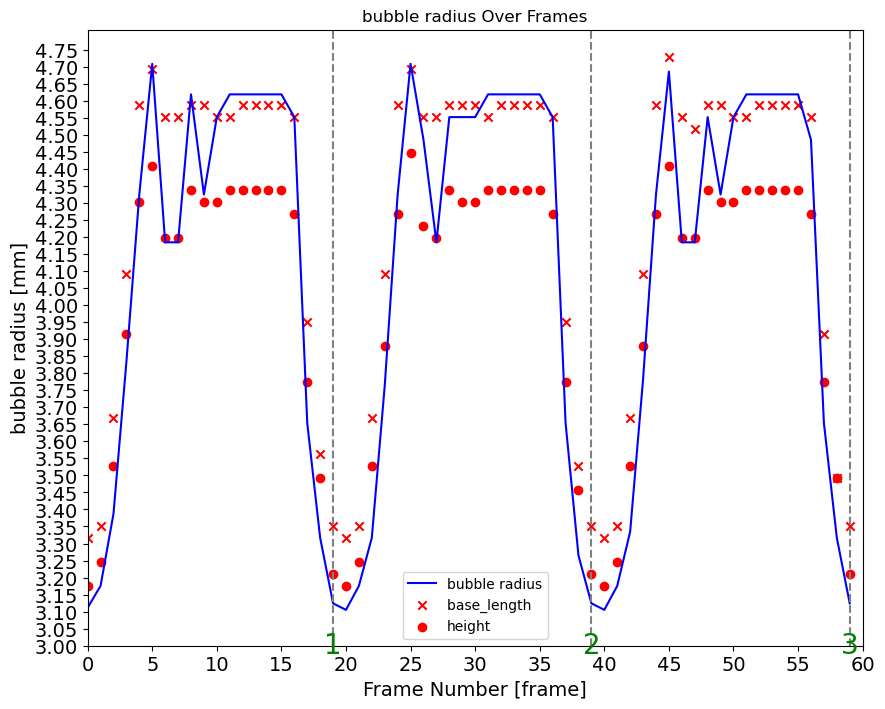

In [1]:
import cv2
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import pixel_converter
from assemble_frames_with_order_numbers import assemble_frames_with_order_numbers
from table_image_generator import create_table_image, find_min_max_avg_table

# ビデオデータの読み込み
filename = "C:\\Users\\flow\\Desktop\\bubbledate\\spherical bubbleGray.mp4"
base_path= "C:\\Users\\flow\\Desktop\\bubble_rasing_result\\"
# 動画ファイルのベース名を取得
video_base_name = os.path.splitext(os.path.basename(filename))[0]

# 動画ごとのディレクトリを作成
video_directory = os.path.join(base_path, video_base_name)
os.makedirs(video_directory, exist_ok=True)  # 既に存在している場合は作成しない
# 新しいフォルダのベース名を指定
folder_names = ["d_image", "d_contours", "d_result", "d_threshold", "d_graph"]

# 新しいフォルダを作成
for folder_name in folder_names:
    new_folder_path = os.path.join(video_directory, folder_name)
    os.makedirs(new_folder_path, exist_ok=True)

# 動画の読み込み
cap = cv2.VideoCapture(filename=filename)
#動画ファイルの情報を取得する
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
hight = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
total_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)
print("総フレーム数: ", total_frame)
print("fps: ", fps)
print("動画の長さ: ", total_frame/fps, "[sec]")
# 動画のdpiを取得
video_path = filename
dpi = pixel_converter.get_video_dpi(video_path)
print(dpi)

frame_count = 0  # フレームのカウントを初期化
prev_cx = None  # 前のフレームの重心 x 座標
prev_cy = None  # 前のフレームの重心 y 座標
# グラフ用のデータ格納リスト
area_data = []
perimeter_data = []
moment_data = []
# 重心距離のデータを格納するリスト
centroid_distance_data = []
speed_data = []  # 速度情報を格納するリスト、最初の値を0に初期化
# 重心の座標を格納するリスト
centroid_x_list = []
centroid_y_list = []
centroid_data = []
radius_data = [] # 半径データを格納するためのリスト
# ㎜単位の速度情報を格納するリスト
speed_mm_per_s_data = []
# ㎜単位の重心y座標を格納するリスト
centroid_y_mm_data = []
# ㎜単位の気泡半径を格納するリスト
sphere_radius_mm_data = []
# フレームを格納するリスト
frames = []
# 水平方向と鉛直方向の気泡径のデータを格納するリスト
base_lengths = []
heights = []
base_length_mm_data = []
height_mm_data = []

# 開始フレームを設定
start_frame = 45  
# 開始フレームまで読み込む
for _ in range(start_frame):
    ret, _ = cap.read()
    if not ret:
        print("Error: Failed to read frames.")
        sys.exit(1)

while cap.isOpened() and frame_count < 60:  # 90枚分の処理を行う
    ret, frame = cap.read()
    if ret:   
        num = frame_count
        path = os.path.join(video_directory, "d_image\\")
        contours_path = os.path.join(video_directory, "d_contours\\")
        result_path = os.path.join(video_directory, "d_result\\")
        threshold_path = os.path.join(video_directory, "d_threshold\\")
        
        image_path = path + "picture{:0=3}.bmp".format(num)
        cv2.imwrite(image_path, frame)

        color_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if color_image is None:
            print(f"Error: Failed to load image from {image_path}")
            sys.exit(1)

        gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
        blurred_image = cv2.bilateralFilter(gray_image, 7, 15, 15 )
        ret, binary = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        thresholds_path = threshold_path + "threshold_picture{:0=3}.bmp".format(num)
        cv2.imwrite(thresholds_path, binary)

        raw_contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        raw_img_with_contours = frame.copy()
        cv2.drawContours(raw_img_with_contours, raw_contours, -1, (0, 255, 0), 2)
        raw_contours_image_path = os.path.join(contours_path, "raw_contours_picture{:0=3}.bmp".format(num))
        cv2.imwrite(raw_contours_image_path, raw_img_with_contours)

        contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        #print(contours)
        conditions = {
            "min_contour_area": 5000,
            "max_contour_area": 20000,
        }

        filtered_contours = []
        area_data = []
        perimeter_data = []
        moment_data = []

        for idx, contour in enumerate(contours):
            contour_area = cv2.contourArea(contour)

            if (
                ("min_contour_area" not in conditions or contour_area >= conditions["min_contour_area"]) and
                ("max_contour_area" not in conditions or contour_area <= conditions["max_contour_area"])
            ):
                filtered_contours.append(contour)
                area_data.append(contour_area)
                perimeter_data.append(cv2.arcLength(contour, True))
                M = cv2.moments(contour)
                filtered_cx = int(M['m10'] / M['m00']) if M["m00"] != 0 else 0
                filtered_cy = int(M['m01'] / M['m00']) if M["m00"] != 0 else 0
                moment_data.append((filtered_cx, filtered_cy))
                
                # 輪郭上の点と重心の距離を計算し、最大距離を半径とし直径を求める
                max_radius = 0
                for point in contour:
                    x, y = point[0]
                    distance = math.sqrt((x - filtered_cx)**2 + (y - filtered_cy)**2)
                    if distance > max_radius:
                        max_radius = distance*2
                radius_data.append(max_radius)

        if len(filtered_contours) > 0:
            result_image = color_image.copy()
        
            for contour, moment in zip(filtered_contours, moment_data):
                x_coordinates = [point[0][0] for point in contour]
                y_coordinates = [point[0][1] for point in contour]
                
                min_x = min(x_coordinates)
                max_x = max(x_coordinates)
                min_y = min(y_coordinates)
                max_y = max(y_coordinates)
                base_length = max_x - min_x
                height = max_y - min_y

                base_lengths.append(base_length)
                heights.append(height)
                
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    filtered_cx, filtered_cy = moment
                    area = cv2.contourArea(contour)
                    # 重心の座標をリストに追加
                    centroid_x_list.append(filtered_cx)
                    centroid_y_list.append(filtered_cy)
                    
                    
                    # 面積を描画
                    #cv2.putText(result_image, f"Area: {area}", (filtered_cx, filtered_cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
                    
                    # 重心に点を描画
                    cv2.circle(result_image, (filtered_cx, filtered_cy), 5, (0, 0, 255), -1)
                    # 輪郭を描画
                    cv2.drawContours(result_image, [contour], -1, (0, 255, 0), 2)
            
            result_image_path = os.path.join(result_path, "result_picture{:0=3}.bmp".format(num))
            frames.append(result_image)
            cv2.imwrite(result_image_path, result_image)
        
        # フレームごとに速度情報を格納
        if prev_cx is not None and prev_cy is not None:
            dx = filtered_cx - prev_cx
            dy = filtered_cy - prev_cy
            centroid_distance = math.sqrt(dx ** 2 + dy ** 2)
            centroid_distance_data.append(centroid_distance)
            dt = 1 / fps  # フレーム間の時間差（秒）
            speed_px_per_s = math.sqrt(dx ** 2 + dy ** 2) / dt
            speed_data.append(speed_px_per_s)
            
            # 重心のデータを追加
            centroid_data.append((filtered_cx, filtered_cy))
        
        # 前のフレームの重心を更新
        prev_cx = filtered_cx
        prev_cy = filtered_cy

        frame_count += 1
    else:
        break

cap.release()  # カメラリソースの解放
cv2.destroyAllWindows()  # ウィンドウの破棄

frame_list = frames  # フレームのリストをここに追加
output_image = assemble_frames_with_order_numbers(frame_list, rows=10, cols=6)
output_result = os.path.join(video_directory, "d_result", "output_image.jpg")
cv2.imwrite(output_result, output_image)
# 画像をジュピター上に表示
plt.imshow(output_image)
plt.show()

# グラフに使用するデータを㎜単位に変換
for centroid_y in centroid_y_list:
    centroid_y_mm_data.append(pixel_converter.pixel_to_mm(centroid_y, dpi))
for speed in speed_data:
    speed_mm_per_s_data.append(pixel_converter.pixel_to_mm(speed, dpi)) 
for sphere_radius in radius_data:
    sphere_radius_mm_data.append(pixel_converter.pixel_to_mm(sphere_radius, dpi))
for base_length in base_lengths:
    base_length_mm_data.append(pixel_converter.pixel_to_mm(base_length, dpi))
for height in heights:
    height_mm_data.append(pixel_converter.pixel_to_mm(height, dpi))
    
#各データの最小最大平均を計算
data1 =  centroid_y_mm_data
data2 =  speed_mm_per_s_data
data3 =  sphere_radius_mm_data
date4 =  base_length_mm_data
date5 =  height_mm_data
# テーブル名
table_name1 = "centroid_y_table"
table_name2 = "speed_table"
table_name3 = "sphere_radius_table"
table_name4 = "base_length_table"
table_name5 = "height_table"
result_table1 = find_min_max_avg_table(data1)
result_table2 = find_min_max_avg_table(data2)
result_table3 = find_min_max_avg_table(data3)
result_table4 = find_min_max_avg_table(date4)
result_table5 = find_min_max_avg_table(date5)

if result_table1:
    image1 = create_table_image(result_table1, table_name1)
    image1_falename = os.path.join(video_directory, "d_graph", "centroid_y_table.png")
    image1.save(image1_falename)
else:
    print("Empty data list.")
    
if result_table2:
    image2 = create_table_image(result_table2, table_name2)
    image2_falename = os.path.join(video_directory, "d_graph", "speed_table.png")
    image2.save(image2_falename)
else:
    print("Empty data list.")
    
if result_table3:
    image3 = create_table_image(result_table3, table_name3)
    image3_falename = os.path.join(video_directory, "d_graph", "sphere_radius_table.png")
    image3.save(image3_falename)
else:
    print("Empty data list.")
if result_table4:
    image4 = create_table_image(result_table4, table_name4)
    image4_falename = os.path.join(video_directory, "d_graph", "base_length_table.png")
    image4.save(image4_falename)
else:
    print("Empty data list.")
if result_table5:
    image5 = create_table_image(result_table5, table_name5)
    image5_falename = os.path.join(video_directory, "d_graph", "height_table.png")
    image5.save(image5_falename)
else:
    print("Empty data list.")

#centroid_y_mm_dataとspeed_mm_per_s_dataを使ってグラフを作成
plt.figure(figsize=(10, 6))  # グラフのサイズを設定
#重心y座標のデータをプロット
plt.plot(centroid_y_mm_data, label='Centroid y', color='blue')
#速度のデータをプロット
plt.plot(speed_mm_per_s_data, label='bubble rasing velocity', color='red')
# グラフのタイトルと軸ラベルを設定
plt.title('Centroid y and Speed Over Frames')
plt.xlabel('Frame Number [frame]', fontsize=14)

plt.xlim(0, 60)
for index, frame in enumerate(range(19, 60, 20), start=1):
    plt.axvline(x=frame, color='gray', linestyle='--')
    plt.text(frame, 4.0, str(index), va='center', ha='center', color='green', fontsize=24)
# ｙ軸のメモリを細かくしたい
plt.xticks(np.arange(0, 65, 5), fontsize=14)
plt.yticks(np.arange(0, 12, 0.5), fontsize=14)
plt.ylabel('bubble rasing velocity [mm/s]', fontsize=20)

# 凡例を表示
plt.legend()
# グラフを保存
graph_filename = os.path.join(video_directory, "d_graph", "centroid_speed_graph.png")
plt.savefig(graph_filename)
# グラフを表示
plt.show()

#sphere_radius_mm_dataを使ってグラフを作成
plt.figure(figsize=(10, 8))  # グラフのサイズを設定
#気泡直径のデータをプロット
plt.plot(sphere_radius_mm_data, label='bubble radius', color='blue')
plt.scatter(range(len(base_length_mm_data)), base_length_mm_data, label='base_length ', color='red', marker='x')
plt.scatter(range(len(height_mm_data)), height_mm_data, label='height', color='red', marker='o')
# グラフのタイトルと軸ラベルを設定
plt.title('bubble radius Over Frames')
plt.xlabel('Frame Number [frame]', fontsize=14)

plt.xlim(0, 60)
for index, frame in enumerate(range(19, 60, 20), start=1):
    plt.axvline(x=frame, color='gray', linestyle='--')
    plt.text(frame, 3.0, str(index), va='center', ha='center', color='green', fontsize=20)

plt.xticks(np.arange(0, 65, 5), fontsize=14)
plt.yticks(np.arange(3.0, 4.8, 0.05), fontsize=14)
plt.ylabel('bubble radius [mm]', fontsize=14)
# 凡例を表示
plt.legend()
# グラフを保存
graph_filename = os.path.join(video_directory, "d_graph", "bubble_radius_graph.png")
plt.savefig(graph_filename)
# グラフを表示
plt.show()


